In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def find_root(graph):
        for node, in_degree in graph.in_degree():
            if in_degree == 0:
                return node

In [3]:
def traversal(graph, root):
    global x_current, y_current #смотрим, на каком мы уровне и на каком по счету узле
    
    kids = list(graph.neighbors(root)) #смотрим всех детей
    n_kids = len(kids) 
    left_kids = kids[:n_kids//2] #левые поддеревья
    right_kids = kids[n_kids//2:] #правый поддеревья
    
    y_current += 1 #увеличиваем, глубину на один для обхода левых поддеревьев и собственно, обходим
    for kid in left_kids:
        traversal(graph, kid) 
        
    y_current -= 1 #возвращаемся на текущий уровень и обходим текущий корень
    graph.nodes[root]["x"] = x_current
    graph.nodes[root]["y"] = y_current
    
    if n_kids % 2 != 1: #если нечетное количество детей - средний потомок - под корнем, иначе - сдвигаем справа
        x_current = x_current + 1
        
    y_current += 1 #
    for kid in right_kids:
        traversal(graph, kid)
    
    y_current -= 1 #возвращаемся на текущий уровень
    graph.depth = y_current if graph.depth < y_current else graph.depth #для дебага считаем глубину  дерева общую

In [4]:
def merge_silhouettes(raw_silhoetes):
    levels = [] # мерджим силуэты поддеревьев
    for d in raw_silhoetes:
        levels.append([min([s[0] for s in raw_silhoetes[d]]), max(s[1] for s in raw_silhoetes[d])])
    return levels

In [5]:
def find_silhouette(graph, root):
    kids = list(graph.neighbors(root))
    graph.nodes[root]["silhouette"] = [[graph.nodes[root]["x"], graph.nodes[root]["x"]]] 
    #в силуэт дерева точно входит силуэт его корня
    
    #создаем силуэты всех поддеревьев
    for kid in kids:
        find_silhouette(graph, kid)
    if len(kids) > 0:
        silhoetes = {} # создаем словарь: глубина: силуэты всех поддеревьев на этой глубине
        for kid in kids: 
            for d in range(len(graph.nodes[kid]["silhouette"])):
                if d in silhoetes:
                    silhoetes[d].append(graph.nodes[kid]["silhouette"][d])
                else:
                    silhoetes[d] = []
                    silhoetes[d].append(graph.nodes[kid]["silhouette"][d])
        
        merged_silhouette = merge_silhouettes(silhoetes) #мерджим словарь в единный силуэт
        graph.nodes[root]["silhouette"] += merged_silhouette # смердженный силуэт всех поддеревьев присоединяется к силуэту корня

In [6]:
def find_shift_between_subtrees(graph, left_subtree_root, right_subtree_root): 
    #берем корень левого поддерева, правого поддерева и смотрим, насколько максимально можно сдвинуть правое дерево, чтобы оно в любой точке было удалень как минимум на олн
    left_subtree_silhouette = graph.nodes[left_subtree_root]["silhouette"] #левый силуэт
    right_subtree_silhouette = graph.nodes[right_subtree_root]["silhouette"] #правый силуэт
    shifts = []
    for d in range(min(len(left_subtree_silhouette), len(right_subtree_silhouette))):
        shifts.append(left_subtree_silhouette[d][1] - right_subtree_silhouette[d][0] + 1) 
    return max(shifts) 

In [7]:
def shift_subtree(graph, root, shift):
    #сдвигаем поддерево на shift
    graph.nodes[root]["x"] += shift 
    kids = list(graph.neighbors(root))
    #сдвигаем всех потомков root на shift
    for kid in kids:
        shift_subtree(graph, kid, shift)

In [8]:
def compress(graph, root):
    #сжимаем поддерево с корнем в root
    kids = list(graph.neighbors(root)) 
    n_kids = len(kids)
    for kid in kids: #сжимаем все поддеревья
            compress(graph, kid)
            
    if n_kids >= 1: #если есть хотя бы один потомок, то мы сжимаем текущее дерево, сдвигая его потомков
        
        for i in range(1, n_kids):
            shifts = []
            for j in range(i): #проверяем не только пересечение с предыдущим деревом, но и со всеми предыдущими (вдруг разрастаются на глубине больше предыдущего)
                shifts.append(find_shift_between_subtrees(graph,  kids[j], kids[i]))
            shift = max(shifts) # смотрим сдвиг максимально допустимный
            shift_subtree(graph, kids[i], shift) #сдвигаем и пересчитываем силуэт сдвинутого поддерева
            find_silhouette(graph, kids[i])
        graph.nodes[root]["x"] = int((max(graph.nodes[node]['x'] for node in kids) + min(graph.nodes[node]['x'] for node in kids)) // 2 ) 
        #помещаем корень посередине между крайними поддеревьями и пересчитываем его силуэт
        find_silhouette(graph, root)

In [9]:
def plot(graph):
        coord = {}
        figure = plt.figure(figsize=(15,15))
        for node in graph.nodes:
            coord[node] = (graph.nodes[node]["x"], -graph.nodes[node]["y"])
        nx.draw_networkx(graph, pos=coord, node_color="b", with_labels=False)

In [10]:
def plot_graph(path, compression=False):
    graph = nx.read_graphml(path) #читаем граф
    graph.root = find_root(graph) #ищем корень
    graph.depth = 0
    global x_current, y_current
    x_current = 0
    y_current = 0
    traversal(graph, graph.root) #обходим граф
    if compression: #если надо - сжимаем
        find_silhouette(graph, graph.root)
        compress(graph, graph.root)
    plot(graph)

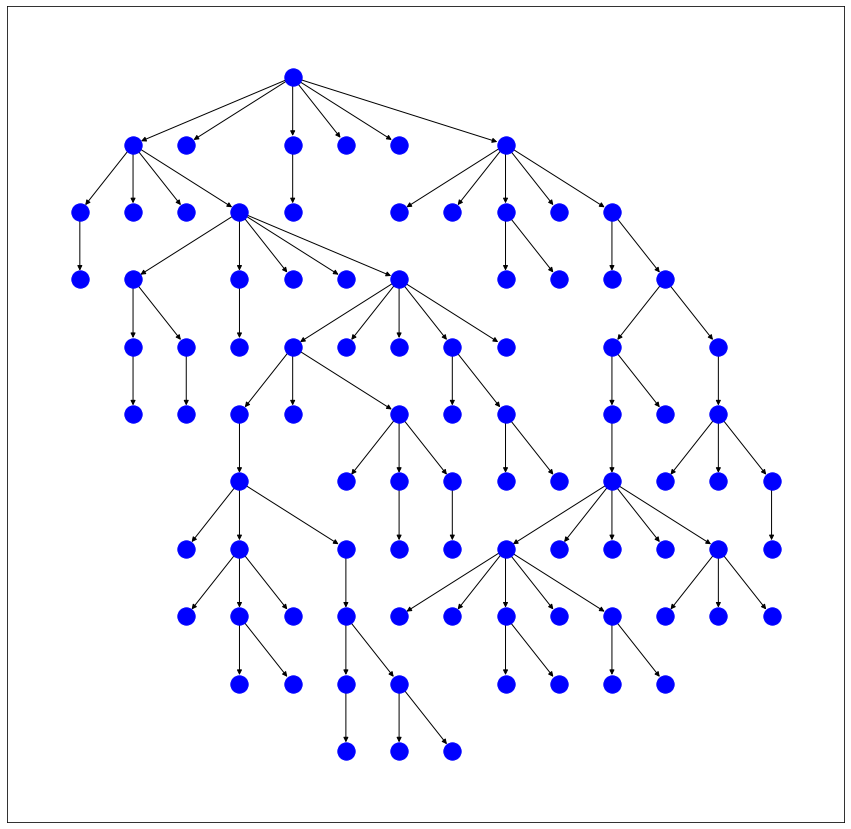

In [11]:
plot_graph("./tree/graphs/tree-test-dense.xml", True)